In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, time
from scipy import stats
from scipy.optimize import curve_fit
from datetime import time
import re

#from scipy.stats import kruskal
#from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [10]:
#### Setup
### Input path to filenames for the time csv and the data csv here: 
data_file = 'holuhraun_atp_total.csv'
time_array = 'time_array.csv'
save_path = ""

extract_vol1 = 5. #Volume of Tris added during extraction 
sample_vol1 = 5. #Weight or volume of sample added (e.g., 5g, L of filtrate, etc.). Set to None if you prefer to do your own calculations later. 


In [11]:
#Read in the data and convert to datetime format 
#Perform the integral for each method using the trapezoid method

def integrate_data(RLU_file, time_file):
    df = pd.read_csv(RLU_file) 
    time_df = pd.read_csv(time_file)
    time_df = time_df.iloc[[0]] 
    time_df.iloc[0] = pd.to_datetime(time_df.iloc[0], format='%H:%M').dt.time
    integrals = {}

    # Loop through each column except the 'Time' column
    for column in df.columns:
        if column != 'Time':
            integral = np.trapz(df[column], df['Time'])
            integrals[column] = integral

    df_total = pd.DataFrame.from_dict(integrals, orient='index', columns=['Integral'])
    time_dict = time_df.iloc[0].to_dict()

# Add the time column to the df by matching on the index
    df_total['Time'] = df_total.index.map(time_dict)
    return (df_total,time_df,integrals)
    
    
df1,time_df1,integrals1=integrate_data(data_file,time_array)

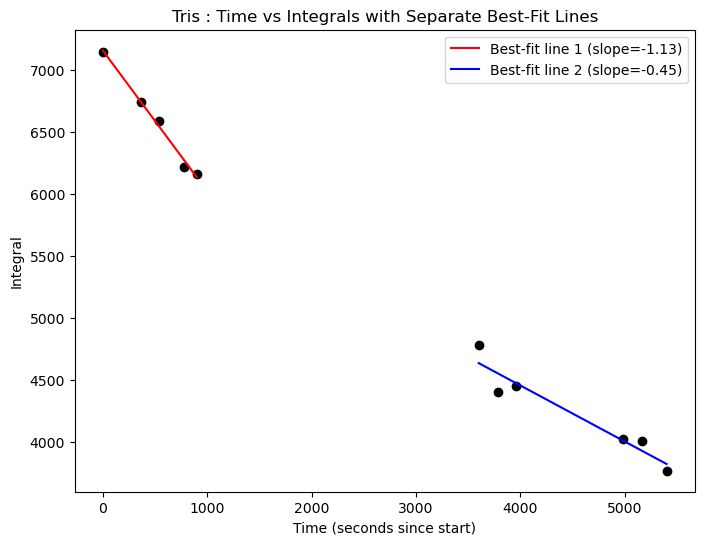

<Figure size 640x480 with 0 Axes>

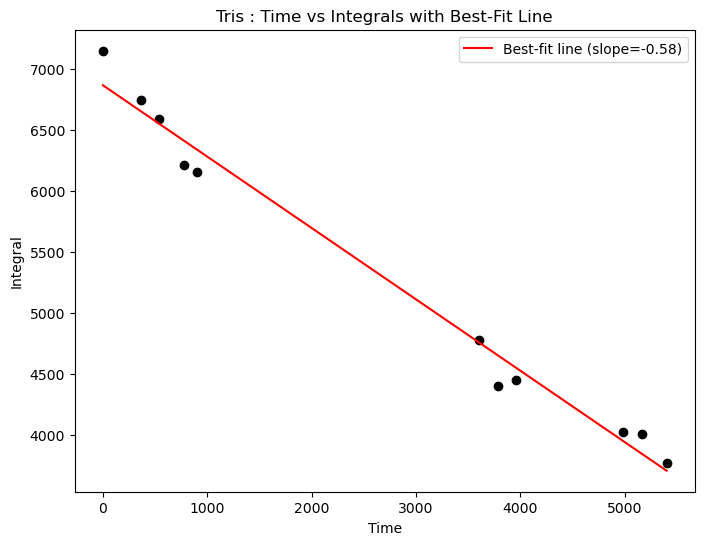

<Figure size 640x480 with 0 Axes>

In [12]:
###The main function takes 4 arguments: the input dataframe, a True/False indicator whether to seperate out the Tris values, and the x bounds. The first xbound is the upper bound of the first line and second is the lower bound of the second line.  
def time_to_seconds_relative(times,min_time1):
    """Convert a list of datetime.time objects to seconds relative to the earliest time (e.g., the start of the experiment)."""
    if isinstance(min_time1, time):
        min_time_in_seconds = min_time1.hour * 3600 + min_time1.minute * 60 + min_time1.second
    else:
        min_time_in_seconds = min_time1
    times_in_seconds = [t.hour * 3600 + t.minute * 60 + t.second if isinstance(t, time) else t for t in times]
    return [t - min_time_in_seconds for t in times_in_seconds]

def plot_tris_samples(df,seperate_tris,x_bound1=None, x_bound2=None):
    # Filter rows that have "Tris" in their index (sample names
    datetime_values = df['Time'][df['Time'].apply(lambda x: isinstance(x, (pd.Timestamp, time)))]
    min_time = min(datetime_values) ##Extract experiment start time for relative measurements 
    
    tris_df = df[df.index.str.contains('Tris')]

    # Extract times and integrals for these samples
    times = tris_df['Time'].values
    integrals = tris_df['Integral'].values
    times_in_seconds = time_to_seconds_relative(times,min_time)
    #times_in_seconds = [time_to_seconds(t) if isinstance(t, time) else t for t in times]

    if seperate_tris == False:
        slope, intercept = np.polyfit(times_in_seconds, integrals, 1)
        best_fit_line = slope * np.array(times_in_seconds) + intercept
        # Plotting the data
        plt.figure(figsize=(8, 6))
        plt.scatter(times_in_seconds, integrals, marker='o', color='k')
        plt.plot(times_in_seconds, best_fit_line, color='r', label=f'Best-fit line (slope={slope:.2f})')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Integral')
        plt.title('Tris : Time vs Integrals with Best-Fit Line')
        plt.show()

        predicted_tris_luminescence = []
        for idx, row in df.iterrows():
            sample_time = row['Time']
            if isinstance(sample_time, time):
                sample_time_in_seconds = time_to_seconds_relative([sample_time],min_time)[0]
            else:
                sample_time_in_seconds = sample_time
            
            # Calculate the predicted Tris luminescence using the curve
            predicted_luminescence = slope * sample_time_in_seconds + intercept
            predicted_tris_luminescence.append(predicted_luminescence)
    
    if seperate_tris == True:
        if x_bound1 is None or x_bound2 is None:
            raise ValueError("x_bound1 and x_bound2 must be provided when separate_tris is True")
        # Split indices based on the x bounds
        mask1 = np.array(times_in_seconds) <= x_bound1
        mask2 = np.array(times_in_seconds) > x_bound1
        
        # Perform linear regression on each subset
        slope1, intercept1 = np.polyfit(np.array(times_in_seconds)[mask1], np.array(integrals)[mask1], 1)
        slope2, intercept2 = np.polyfit(np.array(times_in_seconds)[mask2], np.array(integrals)[mask2], 1)

        # Plotting the data
        plt.figure(figsize=(8, 6))
        plt.scatter(times_in_seconds, integrals, marker='o', color='k')
        plt.plot(np.array(times_in_seconds)[mask1], slope1 * np.array(times_in_seconds)[mask1] + intercept1, color='r', label=f'Best-fit line 1 (slope={slope1:.2f})')
        plt.plot(np.array(times_in_seconds)[mask2], slope2 * np.array(times_in_seconds)[mask2] + intercept2, color='b', label=f'Best-fit line 2 (slope={slope2:.2f})')
        plt.legend()
        plt.xlabel('Time (seconds since start)')
        plt.ylabel('Integral')
        plt.title('Tris : Time vs Integrals with Separate Best-Fit Lines')
        plt.show()

        predicted_tris_luminescence = []
        for idx, row in df.iterrows():
            sample_time = row['Time']
            if isinstance(sample_time, time):
                sample_time_in_seconds = time_to_seconds_relative([sample_time],min_time)[0]
            else:
                sample_time_in_seconds = sample_time
            
            # Calculate the predicted Tris luminescence based on which segment the time falls into
            if sample_time_in_seconds <= x_bound1:
                predicted_luminescence = slope1 * sample_time_in_seconds + intercept1
                
            else:
                predicted_luminescence = slope2 * sample_time_in_seconds + intercept2

            predicted_tris_luminescence.append(predicted_luminescence)

    # Add the predicted Tris luminescence to the DataFrame
    df['Predicted_Tris_Luminescence'] = predicted_tris_luminescence
    df['Corrected_Luminescence'] = df['Integral'] - df['Predicted_Tris_Luminescence']
    for index, row in df.iterrows(): # set negative values to 0
        if row['Corrected_Luminescence'] < 0: 
            df.at[index, 'Corrected_Luminescence'] = 0. 
    plt.savefig(save_path+"Tris_vs_Time.png")
    return (df)

df1 = plot_tris_samples(df1,True, x_bound1=2500,x_bound2=2501)
df2 = plot_tris_samples(df1,False)

In [13]:
#pd.set_option('display.max_rows', 100) 
#pd.reset_option('all')

In [14]:
# Define a function to extract the concentration of standards
def extract_concentration(index):
    if index.startswith('0.'):
        # For concentrations less than 1, match '0.X' where X is digits
        match = re.match(r'^0\.\d+', index)
        if match:
            return float(match.group())
    elif index[0].isdigit():
        # For concentrations greater than or equal to 1, match digits before any dot
        match = re.match(r'^(\d+)', index)
        if match:
            return float(match.group())
    return None  # For non-standard indices like 'Tris'

# Apply the function to the index
df1['Standard_Concentration'] = df1.index.to_series().apply(extract_concentration)


/Users/hadland/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/hadland/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hadland/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

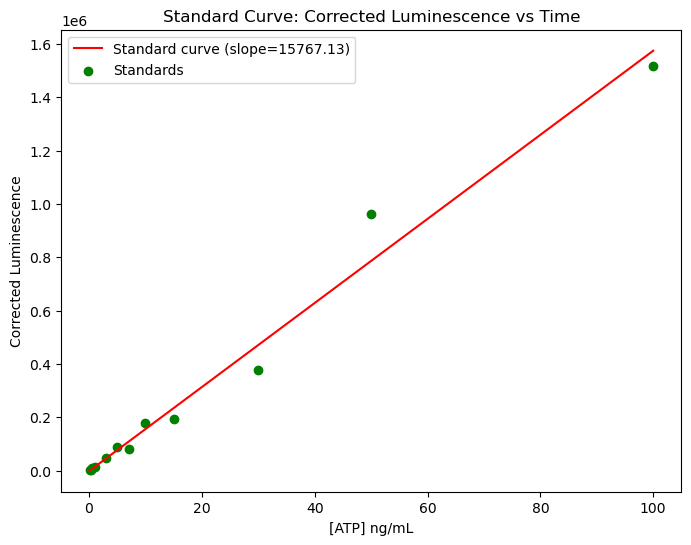

In [15]:
def calculate_sample_concentration(df,extract_vol,sample_vol=None):
    # Extract the number before the first decimal in the index, if it exists
    # For small values like "0.5" and "0.1", keep them intact
    # Group by the standard names and calculate mean values for times and corrected luminescence
    
    standard_df = df.dropna(subset=['Standard_Concentration']).groupby('Standard_Concentration').mean().reset_index()
    dropped_rows = df[df['Standard_Concentration'].isna()]
    samples = dropped_rows[~dropped_rows.index.str.contains('Tris', na=False)]
    
    # Extract times and corrected luminescence for the standards
    corrected_luminescence = standard_df['Corrected_Luminescence'].values
    concentrations = standard_df["Standard_Concentration"].values 


    # Calculate the best fit line for the standards (standard curve)
    standard_slope, standard_intercept = np.polyfit(concentrations, corrected_luminescence, 1)
    samples['Concentration [ng/mL]'] = dropped_rows['Corrected_Luminescence'] / standard_slope
    if sample_vol == None: 
        samples["Original_Sample_Concentration"] = samples["Concentration [ng/mL]"] * extract_vol 
    else: 
        samples["Original_Sample_Concentration"] = samples["Concentration [ng/mL]"] * extract_vol / sample_vol
    # Generate the best fit line for the standard curve
    best_fit_standard_curve = standard_slope * np.array(concentrations) + standard_intercept

    #These lines make a new column if there are triplicate samples and rename a new column without the numbered indices. 
    samples.index = samples.index.astype(str)
    samples['Base_Sample'] = samples.index.str.split('.').str[0]

    # Plot the standard curve
    plt.figure(figsize=(8, 6))
    plt.scatter(concentrations, corrected_luminescence, marker='o', color='g', label='Standards')
    plt.plot(concentrations, best_fit_standard_curve, color='r', label=f'Standard curve (slope={standard_slope:.2f})')
    plt.xlabel('[ATP] ng/mL')
    plt.ylabel('Corrected Luminescence')
    plt.title('Standard Curve: Corrected Luminescence vs Time')
    plt.legend()
    plt.savefig(save_path+"ATP_Standard_Curve.png")
    plt.show()
    
    return (samples)
    
samples1 = calculate_sample_concentration(df1,extract_vol1,sample_vol=sample_vol1)
samples1.to_csv(save_path+"atp_results.csv", sep=',', index=True)

